In [1]:
import keras
from matplotlib import pyplot as pl
import numpy as np
import gzip
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.models import Model
from keras.optimizers import RMSprop
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import metrics
from keras.utils import to_categorical

%matplotlib inline

In [2]:
!git clone https://github.com/davidflanagan/notMNIST-to-MNIST.git

Cloning into 'notMNIST-to-MNIST'...
remote: Enumerating objects: 22, done.
remote: Total 22 (delta 0), reused 0 (delta 0), pack-reused 22
Receiving objects: 100% (22/22), 22.14 MiB | 11.31 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [3]:
def extract_data(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(28 * 28 * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, 28,28)
        return data

def extract_labels(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        return labels

# Create dictionary of target classes
label_dict = {
 0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'J',
}

In [4]:
train_data = extract_data('notMNIST-to-MNIST/train-images-idx3-ubyte.gz', 60000)
test_data = extract_data('notMNIST-to-MNIST/t10k-images-idx3-ubyte.gz', 10000)

train_labels = extract_labels('notMNIST-to-MNIST/train-labels-idx1-ubyte.gz',60000)
test_labels = extract_labels('notMNIST-to-MNIST/t10k-labels-idx1-ubyte.gz',10000)

X_train = train_data.reshape(-1, 28,28, 1)  # add grey channel
X_test = test_data.reshape(-1, 28,28, 1)

n_classes = 10
Y_train = to_categorical(train_labels, n_classes) # 1-hot
Y_test = to_categorical(test_labels, n_classes)
print(Y_train[:10])

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


In [5]:
# Shape of training set
print("Training set (images) shape: {shape}".format(shape=X_train.shape))
# Shape of test set
print("Test set (images) shape: {shape}".format(shape=X_test.shape))
# Type of data - should be float32
print('data type: ', X_train.dtype, X_test.dtype)

Training set (images) shape: (60000, 28, 28, 1)
Test set (images) shape: (10000, 28, 28, 1)
data type:  float32 float32


Text(0.5, 1.0, '(Label: D)')

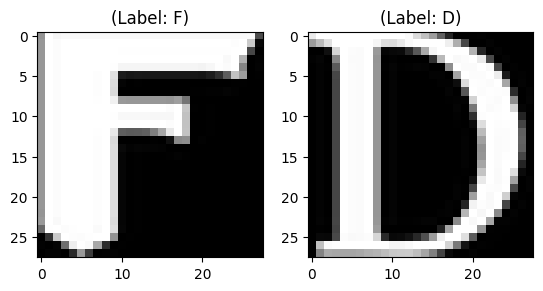

In [6]:
# Display the first image in training data
pl.subplot(121)
curr_img = np.reshape(X_train[0], (28,28))
curr_lbl = train_labels[0]
pl.imshow(curr_img, cmap='gray')
pl.title("(Label: " + str(label_dict[curr_lbl]) + ")")

# Display the first image in testing data
pl.subplot(122)
curr_img = np.reshape(X_test[0], (28,28))
curr_lbl = test_labels[0]
pl.imshow(curr_img, cmap='gray')
pl.title("(Label: " + str(label_dict[curr_lbl]) + ")")

In [7]:
# rescale the data in range 0-1
X_train = X_train / 255.0
X_test = X_test / 255.0

## Create a shallow MLP encoder

In [8]:
# STARTING FROM HERE, COMPLETE THE CODE WHERE YOU SEE ...
# size of our encoded representation
encoding_dim = 32  # this is the number of neurons you chose to encode

# define input layer, encoded layer and decoded layer
input_img = Input(shape=(784,))
encoded =  Dense(encoding_dim, activation='relu')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)

# define autoencoder model
autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))

# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]

# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [9]:
# compile the network
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [10]:
# for visualiztion
def plot_result(x_test,decoded_imgs):
    n = 10
    pl.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = pl.subplot(2, n, i + 1)
        pl.imshow(x_test[i].reshape(28, 28))
        pl.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = pl.subplot(2, n, i + 1 + n)
        pl.imshow(decoded_imgs[i].reshape(28, 28))
        pl.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    pl.show()

In [11]:
X_train_flat = X_train.reshape(60000,784)
X_test_flat = X_test.reshape(10000,784)

In [12]:
# train the network
log = autoencoder.fit(X_train_flat, X_train_flat, epochs=50, batch_size=256, shuffle=True, validation_data=(X_test_flat, X_test_flat))

Epoch 1/50
235/235 [==============================] - 4s 6ms/step - loss: 0.4398 - val_loss: 0.2954
Epoch 2/50
235/235 [==============================] - 1s 6ms/step - loss: 0.2897 - val_loss: 0.2381
Epoch 3/50
235/235 [==============================] - 1s 6ms/step - loss: 0.2483 - val_loss: 0.2142
Epoch 4/50
235/235 [==============================] - 1s 6ms/step - loss: 0.2309 - val_loss: 0.2043
Epoch 5/50
235/235 [==============================] - 1s 5ms/step - loss: 0.2232 - val_loss: 0.1987
Epoch 6/50
235/235 [==============================] - 1s 4ms/step - loss: 0.2188 - val_loss: 0.1955
Epoch 7/50
235/235 [==============================] - 1s 5ms/step - loss: 0.2160 - val_loss: 0.1933
Epoch 8/50
235/235 [==============================] - 1s 4ms/step - loss: 0.2144 - val_loss: 0.1920
Epoch 9/50
235/235 [==============================] - 1s 4ms/step - loss: 0.2133 - val_loss: 0.1914
Epoch 10/50
235/235 [==============================] - 1s 5ms/step - loss: 0.2125 - val_loss: 0.1908

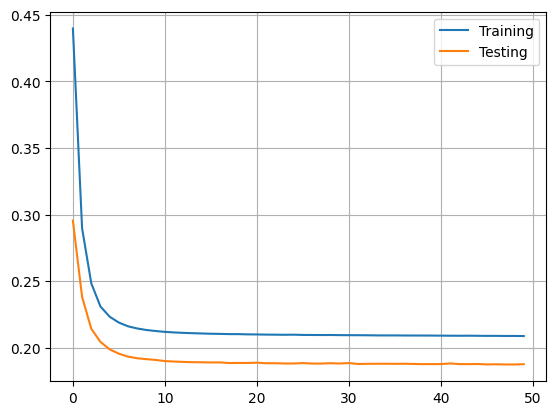

In [13]:
pl.plot(log.history['loss'], label='Training')
pl.plot(log.history['val_loss'], label='Testing')
pl.legend()
pl.grid()

313/313 [==============================] - 1s 1ms/step


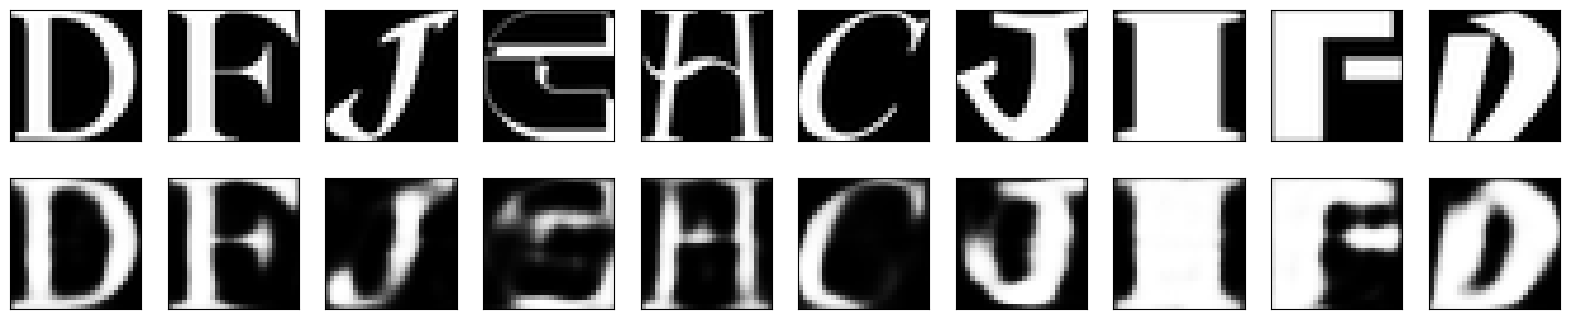

In [14]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(X_test_flat)
decoded_imgs = decoder.predict(encoded_imgs)
plot_result(X_test_flat,decoded_imgs)

### Use the encoded features to train another classifier

In [15]:
X_train_feat = encoder.predict(X_train_flat)
X_test_feat = encoder.predict(X_test_flat)

# Normalization (standardization) of training and test sets
scaler = StandardScaler()
scaler.fit(X_train_feat)
X_train_feat = scaler.transform(X_train_feat)
X_test_feat = scaler.transform(X_test_feat)

print(X_train_feat.shape)
print(Y_train.shape)
print(X_test_feat.shape)
print(Y_test.shape)

313/313 [==============================] - 0s 1ms/step
(60000, 32)
(60000, 10)
(10000, 32)
(10000, 10)


In [16]:
# using the features
clf = SVC(kernel='linear', cache_size=7000)
clf.fit(X_train_feat, train_labels)

SVC(cache_size=7000, kernel='linear')

In [17]:
y_pred = clf.predict(X_test_feat)

# Print classification results with confusion matrix
print("Classification report for classifier %s:\n%s\n" %
      (clf, metrics.classification_report(test_labels, y_pred)))
# print("\nConfusion matrix:\n%s" % metrics.confusion_matrix(test_labels, y_pred))

Classification report for classifier SVC(cache_size=7000, kernel='linear'):
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1000
           1       0.89      0.87      0.88      1000
           2       0.90      0.92      0.91      1000
           3       0.92      0.90      0.91      1000
           4       0.91      0.88      0.89      1000
           5       0.90      0.94      0.92      1000
           6       0.88      0.87      0.88      1000
           7       0.91      0.89      0.90      1000
           8       0.88      0.86      0.87      1000
           9       0.87      0.94      0.90      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000




## Create a conv autoencoder

In [18]:
input_img = Input(shape=(28, 28, 1))
# encoder
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
# decoder
conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 128
up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 64
up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
# autoencoder
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)         7385

In [19]:
log = autoencoder.fit(X_train, X_train, epochs=50, batch_size=256, shuffle=True, validation_data=(X_test, X_test))

Epoch 1/50
235/235 [==============================] - 11s 26ms/step - loss: 0.2075 - val_loss: 0.1448
Epoch 2/50
235/235 [==============================] - 5s 22ms/step - loss: 0.1508 - val_loss: 0.1322
Epoch 3/50
235/235 [==============================] - 5s 22ms/step - loss: 0.1445 - val_loss: 0.1280
Epoch 4/50
235/235 [==============================] - 5s 21ms/step - loss: 0.1406 - val_loss: 0.1275
Epoch 5/50
235/235 [==============================] - 5s 22ms/step - loss: 0.1381 - val_loss: 0.1241
Epoch 6/50
235/235 [==============================] - 5s 23ms/step - loss: 0.1363 - val_loss: 0.1228
Epoch 7/50
235/235 [==============================] - 5s 22ms/step - loss: 0.1349 - val_loss: 0.1224
Epoch 8/50
235/235 [==============================] - 5s 22ms/step - loss: 0.1337 - val_loss: 0.1210
Epoch 9/50
235/235 [==============================] - 5s 22ms/step - loss: 0.1328 - val_loss: 0.1200
Epoch 10/50
235/235 [==============================] - 5s 22ms/step - loss: 0.1320 - val_l

### Predict on test data

In [20]:
decoded_imgs = autoencoder.predict(X_test, verbose=1)
print(decoded_imgs.shape)

313/313 [==============================] - 1s 2ms/step
(10000, 28, 28, 1)


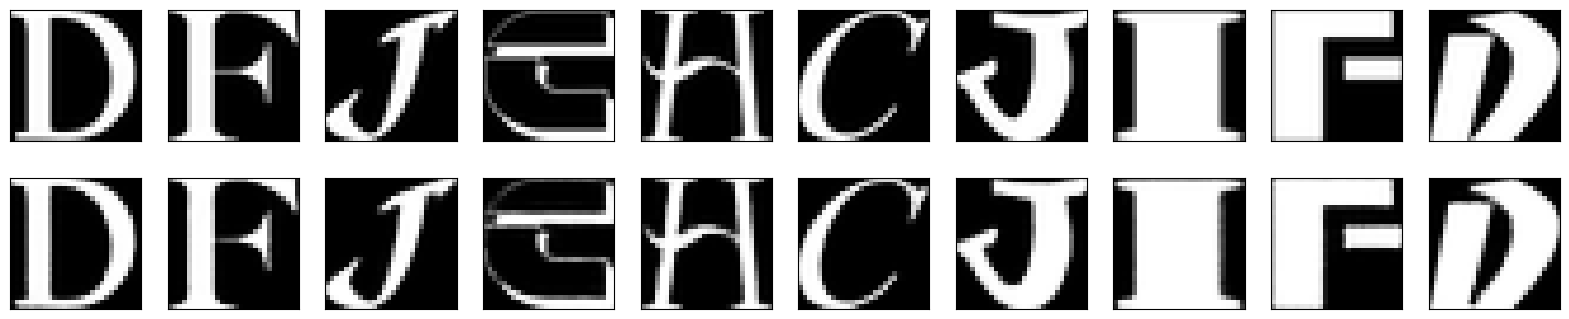

In [21]:
plot_result(X_test_flat,decoded_imgs)

## Denoising autoencoder
First add some noise.

In [22]:
noise_factor = 0.5
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)
X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

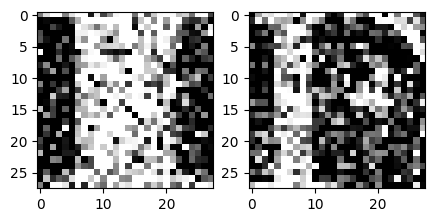

In [23]:
pl.figure(figsize=[5,5])

# Display the first image in training data
pl.subplot(121)
curr_img = np.reshape(X_train_noisy[1], (28,28))
pl.imshow(curr_img, cmap='gray')

# Display the first image in testing data
pl.subplot(122)
curr_img = np.reshape(X_test_noisy[1], (28,28))
pl.imshow(curr_img, cmap='gray')

In [24]:
# REDEFINE HERE A CONV AUTOENCODER FOR THE DENOISING WITH A SIMILAR ARCHITECTURE
input_img = Input(shape=(28, 28, 1))
# encoder
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
# decoder
conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 128
up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 64
up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
# autoencoder
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 7, 128)         7385

In [25]:
# train on the noisy images and use as target the original clean images
log = autoencoder.fit(X_train_noisy, X_train, batch_size=128, epochs=1,
                        verbose=1, validation_data=(X_test_noisy, X_test))

469/469 [==============================] - 9s 13ms/step - loss: 0.2332 - val_loss: 0.1805


In [26]:
decoded_imgs = autoencoder.predict(X_test_noisy, verbose=1)
print(decoded_imgs.shape)

313/313 [==============================] - 1s 2ms/step
(10000, 28, 28, 1)


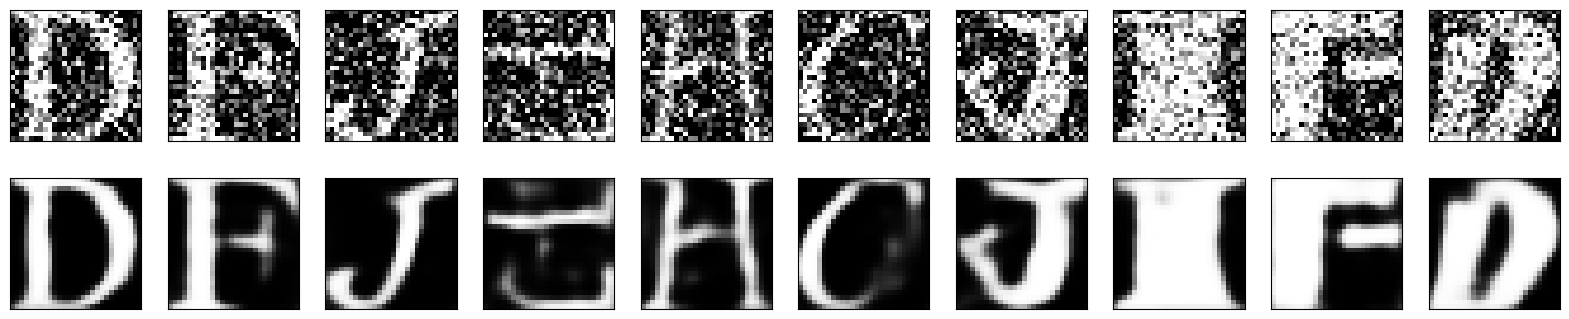

In [27]:
plot_result(X_test_noisy,decoded_imgs)